In [ ]:
import numpy as np
from csv_utils import load_model_data
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": False, # Remove this line if your code doesn't run/ take too long
    # "font.family": 'Times New Roman',
    "figure.dpi": 100,
    "font.size": 14
})


In [ ]:
csv_file = 'data.csv'
full_data = load_model_data(csv_file,load_gauge_fidelity=True)

In [ ]:
import numpy as np

# Convert to numpy
F_naive = np.array(full_data['model_average_fidelity'])
F = np.array(full_data['model_average_fidelity_gauge'])
P = np.array(full_data['P_vector'], dtype=object)

# ---- 1. FILTER FIRST ----
# mask = F > 0.6

# F_naive = F_naive[mask]
# F = F[mask]
# P = P[mask]

# ---- 2. SHUFFLE ----
n = len(F)
perm = np.random.permutation(n)

F_naive = F_naive[perm]
F = F[perm]
P = P[perm]

# ---- 3. SPLIT ----
split = int(0.9 * n)

F_naive_train, F_naive_test = F_naive[:split], F_naive[split:]
F_train, F_test = F[:split], F[split:]
P_train, P_test = P[:split], P[split:]

# ---- 4. (Optional) back to lists ----
F_naive_train = F_naive_train.tolist()
F_naive_test  = F_naive_test.tolist()
F_train = F_train.tolist()
F_test  = F_test.tolist()
P_train = P_train.tolist()
P_test  = P_test.tolist()


In [ ]:
P_avg = [sum(pvector)/3 for pvector in P]

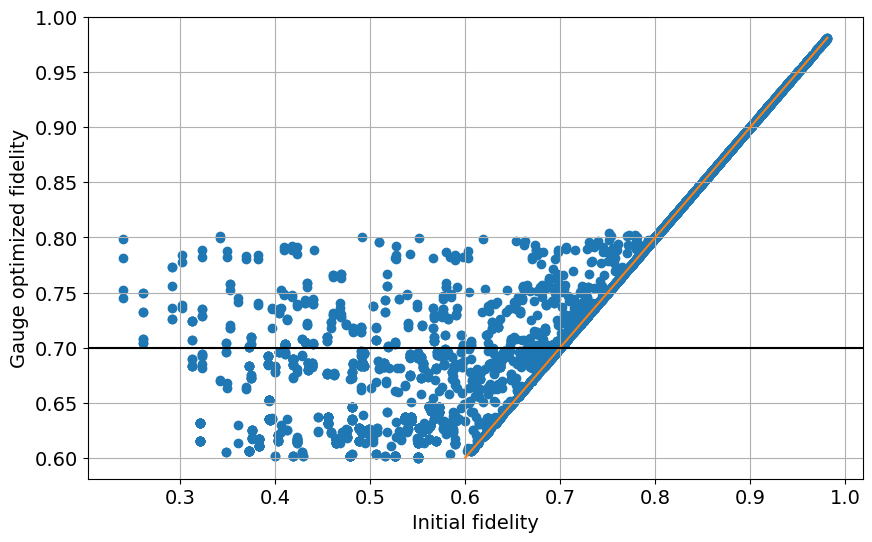

In [ ]:
plt.scatter(F_naive,F)
plt.plot([min(F),max(F)],[min(F),max(F)],color = 'C1')
plt.xlabel('Initial fidelity')
plt.ylabel('Gauge optimized fidelity')
plt.grid()
plt.axhline(y=0.7,color='k')

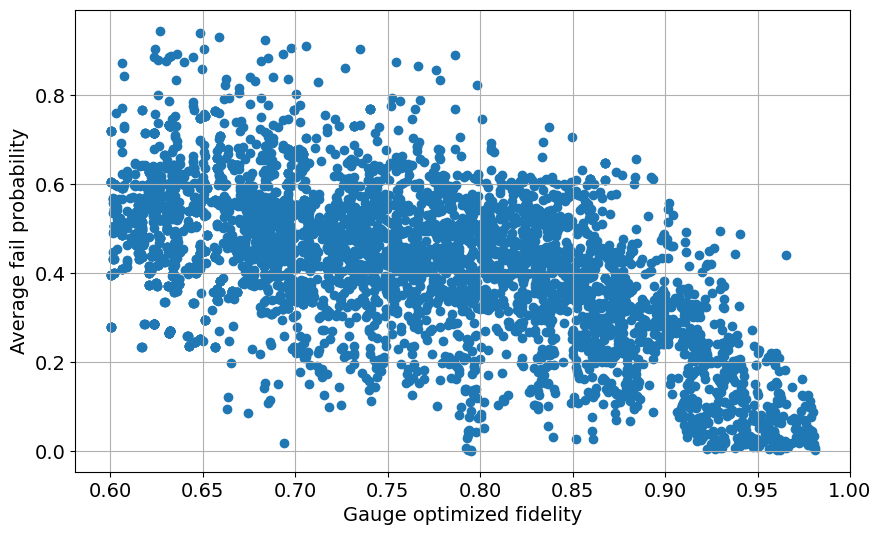

In [ ]:
P_avg = [sum(pvector)/3 for pvector in P]
plt.scatter(F,P_avg)
# plt.plot([min(F),max(F)],[min(F),max(F)],color = 'C1')
plt.xlabel('Gauge optimized fidelity')
plt.ylabel('Average fail probability')
plt.grid()
# plt.axhline(y=0.7,color='k')

In [ ]:
# Convert to PyTorch tensors
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(P_train, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F_train, dtype=torch.float32).unsqueeze(1)  # output: fidelity


dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3, 256),
    nn.GELU(),
    nn.Linear(256, 256),
    nn.GELU(),
    nn.Linear(256, 128),
    nn.GELU(),
    nn.Linear(128, 1)
)


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=200
)


losses = []
# -----------------------------
# Training loop
# -----------------------------
epochs = 3000
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 50, Loss: 0.004950
Epoch 100, Loss: 0.006589
Epoch 150, Loss: 0.002745
Epoch 200, Loss: 0.005487
Epoch 250, Loss: 0.004211
Epoch 300, Loss: 0.005120
Epoch 350, Loss: 0.004764
Epoch 400, Loss: 0.005822
Epoch 450, Loss: 0.003936
Epoch 500, Loss: 0.005538
Epoch 550, Loss: 0.005099
Epoch 600, Loss: 0.007210
Epoch 650, Loss: 0.003417
Epoch 700, Loss: 0.003325
Epoch 750, Loss: 0.005198
Epoch 800, Loss: 0.005420
Epoch 850, Loss: 0.004275
Epoch 900, Loss: 0.005341
Epoch 950, Loss: 0.004399
Epoch 1000, Loss: 0.003972
Epoch 1050, Loss: 0.003985
Epoch 1100, Loss: 0.004464
Epoch 1150, Loss: 0.003942
Epoch 1200, Loss: 0.004451
Epoch 1250, Loss: 0.005828
Epoch 1300, Loss: 0.006069
Epoch 1350, Loss: 0.004086
Epoch 1400, Loss: 0.004076
Epoch 1450, Loss: 0.003485
Epoch 1500, Loss: 0.004185
Epoch 1550, Loss: 0.002958
Epoch 1600, Loss: 0.004641
Epoch 1650, Loss: 0.003132
Epoch 1700, Loss: 0.005185
Epoch 1750, Loss: 0.003639
Epoch 1800, Loss: 0.003570
Epoch 1850, Loss: 0.004571
Epoch 1900, Loss: 0.0

In [ ]:
pred = model(X)
print(pred.std(), y.std())


tensor(0.0737, grad_fn=<StdBackward0>) tensor(0.1027)


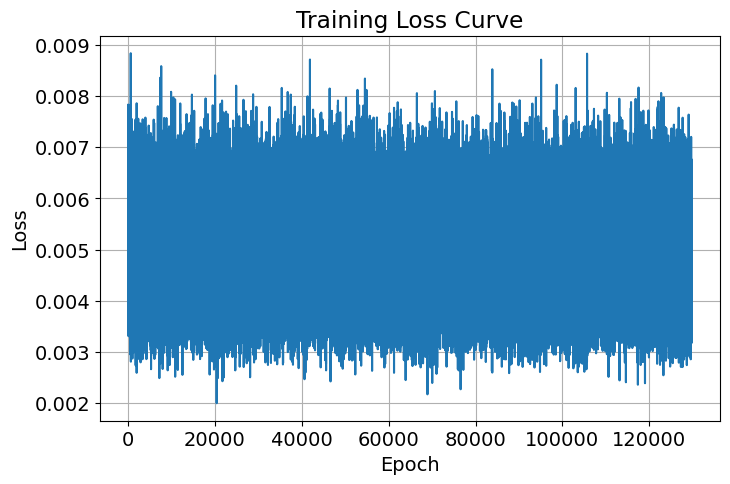

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses[200:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
baseline = ((y - y.mean())**2).mean()
print("Baseline MSE:", baseline.item())


Baseline MSE: 0.010548537597060204


In [ ]:
# Test prediction
F_predicted = []
for P in P_test:
    _P_test_tensor = torch.tensor(P).unsqueeze(0)  # Batch dimension (1 sample)
    _prediction = model(_P_test_tensor).detach().numpy().flatten()
    F_predicted.append(_prediction)

Slope: 0.5125823151641749
Intercept: 0.3702568482973598
R-squared: 0.5259796912925937


/tmp/ipykernel_16254/473903735.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([min(F_test), max(F_test)], [min(F_test), max(F_test)], 'r--', color='C1', label='Ideal 1:1 Line')


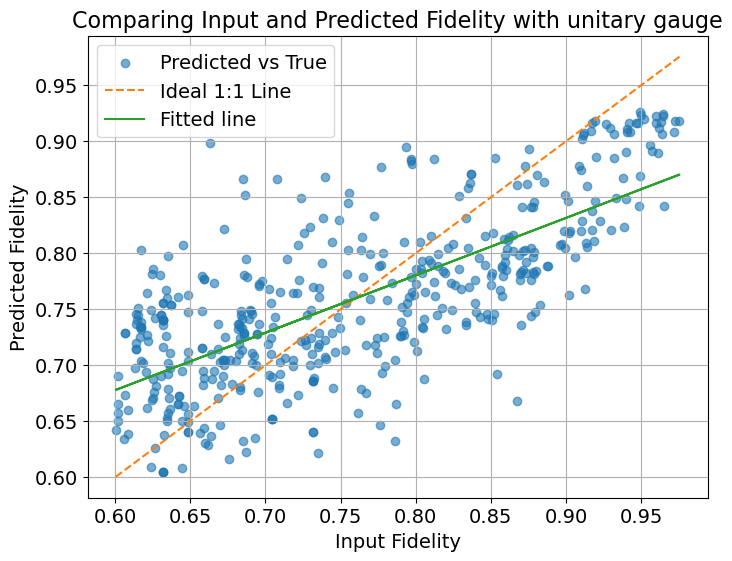

In [ ]:
from scipy import stats
# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(F_test, F_predicted, label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(F_test), max(F_test)], [min(F_test), max(F_test)], 'r--', color='C1', label='Ideal 1:1 Line')


x = np.array(F_test)
y = np.array([float(f[0]) for f in F_predicted])


# Fit a straight line using SciPy
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Generate fitted line
y_fit = slope * x + intercept
plt.plot(F_test, y_fit, color='C2', label="Fitted line")


# Labels and title
plt.xlabel("Input Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("Comparing Input and Predicted Fidelity with unitary gauge", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
type(F_test[0])

float

In [ ]:
type(y[0])

numpy.float64